# Adding features
This Jupyter Notebook will do some data processing and add additional features to the volume dataset. <br>
It will calculate the charging station supply and the EV cgarging demand for each edge. <br>
In addition the notebook will try to visualize some findings in the difference between served/underserved/partially served edges.  

Import relevant packages and files:

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.interpolate import make_interp_spline, UnivariateSpline
import numpy as np
import json
from json import JSONEncoder
import ast
import seaborn as sns

os.environ['USE_PYGEOS']='0' # Hva er dette?

# Display all columns in the df
pd.set_option('display.max_columns', None)
# Set the float format to display numbers in standard decimal notation
pd.options.display.float_format = '{:.5f}'.format

In [89]:
#Read dataset
#df=pd.read_csv('/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/FinalDataProcessing/AddingFeatures/2_InputData/graph_w_CS_and_volume_wCorrectLength.csv')
#df=pd.read_excel('/Users/filipmoennilsen/Downloads/CS_Volume_Roads.xlsx')
df=pd.read_csv('/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/FinalDataProcessing/AddingFeatures/1_PythonScripts/notes_drafts/3_output/missingCS_data_with_volume.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df

,source,target,length,Name_2,ID_2,geometry,unique_id,traffic_id,volume,1,2,3,4,5,6,7,8,9,10,11,12
0,954272,279457,10460.10809,NaN,NaN,MULTILINESTRING ((9.038838694405207 58.7554120...,954272_279457,15882V21841,948.00000,948.00000,1066.00000,1116.00000,1086.00000,1154.00000,1255.00000,1294.00000,NaN,NaN,NaN,NaN,NaN
1,1306725,892553,16944.55074,NaN,NaN,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_892553,08002V181261,10201.00000,10201.00000,11083.00000,10841.00000,10668.00000,10862.00000,11847.00000,NaN,12423.00000,NaN,NaN,NaN,NaN
2,1306725,613853,17910.82374,NaN,NaN,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_613853,08002V181261,10201.00000,10201.00000,11083.00000,10841.00000,10668.00000,10862.00000,11847.00000,NaN,12423.00000,NaN,NaN,NaN,NaN
3,1306725,246612,11239.09381,NaN,NaN,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_246612,08002V181261,10201.00000,10201.00000,11083.00000,10841.00000,10668.00000,10862.00000,11847.00000,NaN,12423.00000,NaN,NaN,NaN,NaN
4,626111,246612,12162.60912,NaN,NaN,MULTILINESTRING ((9.525987851154536 59.6316909...,626111_246612,36539V181297,2125.00000,2125.00000,2523.00000,2577.00000,2277.00000,2382.00000,2768.00000,3337.00000,3112.00000,2881.00000,2694.00000,2188.00000,2101.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,973638,973930,16599.43953,NaN,NaN,MULTILINESTRING ((26.139194165036866 70.302533...,973638_973930,14490V930350,251.00000,251.00000,305.00000,342.00000,367.00000,438.00000,554.00000,858.00000,683.00000,488.00000,361.00000,323.00000,260.00000
254,973930,1818925,15500.51499,NaN,NaN,MULTILINESTRING ((26.565130981516866 70.341708...,973930_1818925,14490V930350,251.00000,251.00000,305.00000,342.00000,367.00000,438.00000,554.00000,858.00000,683.00000,488.00000,361.00000,323.00000,260.00000
255,832749,1101914,17561.22246,NaN,NaN,MULTILINESTRING ((27.33086343693628 70.4436216...,832749_1101914,14490V930350,251.00000,251.00000,305.00000,342.00000,367.00000,438.00000,554.00000,858.00000,683.00000,488.00000,361.00000,323.00000,260.00000
256,1101914,1007500,15461.23499,NaN,NaN,MULTILINESTRING ((27.80045221095047 70.4386256...,1101914_1007500,14490V930350,251.00000,251.00000,305.00000,342.00000,367.00000,438.00000,554.00000,858.00000,683.00000,488.00000,361.00000,323.00000,260.00000


## Data Processing

Adding EV Range (300kwh):

In [90]:
#Adding range of vehicles, lot of analysis to be done here (can also create custom ranges for for different regions...)
df["range"]=300

Change Column Names:

In [93]:
# Manually change the column names
new_names = {'1': 'vol_jan', '2': 'vol_feb', '3': 'vol_mar', '4': 'vol_apr', '5': 'vol_may', '6': 'vol_jun', '7': 'vol_jul', '8': 'vol_aug', '9': 'vol_sep', '10': 'vol_oct', '11': 'vol_nov', '12': 'vol_dec'}
#new_names = {1: 'vol_jan', 2: 'vol_feb', 3: 'vol_mar', 4: 'vol_apr', 5: 'vol_may', 6: 'vol_jun', 7: 'vol_jul', 8: 'vol_aug', 9: 'vol_sep', 10: 'vol_oct', 11: 'vol_nov', 12: 'vol_dec'}
df = df.rename(columns=new_names)       # Rename the columns using the dictionary
df.head(2)

,source,target,length,Name_2,ID_2,geometry,unique_id,traffic_id,volume,vol_jan,vol_feb,vol_mar,vol_apr,vol_may,vol_jun,vol_jul,vol_aug,vol_sep,vol_oct,vol_nov,vol_dec,range
0,954272,279457,10460.10809,NaN,NaN,MULTILINESTRING ((9.038838694405207 58.7554120...,954272_279457,15882V21841,948.00000,948.00000,1066.00000,1116.00000,1086.00000,1154.00000,1255.00000,1294.00000,NaN,NaN,NaN,NaN,NaN,300
1,1306725,892553,16944.55074,NaN,NaN,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_892553,08002V181261,10201.00000,10201.00000,11083.00000,10841.00000,10668.00000,10862.00000,11847.00000,NaN,12423.00000,NaN,NaN,NaN,NaN,300


Fill missing values in volume columns:

In [104]:
#Fill missing values of the original volume observations
#This logic for filling blanks can be significantly improved. Instead, find ratio of every month of total for all observations and fill missing values by using this ratio of the total

# Loop through each row of the dataframe
for index, row in df.iterrows():
    # Calculate the mean of the non-missing values in the row
    #row_mean = int(row[['vol_jan', 'vol_feb', 'vol_mar', 'vol_apr', 'vol_may', 'vol_jun', 'vol_jul', 'vol_aug', 'vol_sep', 'vol_oct', 'vol_nov', 'vol_dec']].mean(skipna=True))
    row_mean = row[['vol_jan', 'vol_feb', 'vol_mar', 'vol_apr', 'vol_may', 'vol_jun', 'vol_jul', 'vol_aug', 'vol_sep', 'vol_oct', 'vol_nov', 'vol_dec']].mean(skipna=True)

    # Fill the missing values in the row with the row mean
    df.loc[index] = row.fillna(row_mean)

df

,source,target,length,Name_2,ID_2,geometry,unique_id,traffic_id,volume,vol_jan,vol_feb,vol_mar,vol_apr,vol_may,vol_jun,vol_jul,vol_aug,vol_sep,vol_oct,vol_nov,vol_dec,range,actual_range_jan,actual_range_feb,actual_range_mar,actual_range_apr,actual_range_may,actual_range_jun,actual_range_jul,actual_range_aug,actual_range_sep,actual_range_oct,actual_range_nov,actual_range_dec,charge_prob_jan,charge_prob_feb,charge_prob_mar,charge_prob_apr,charge_prob_may,charge_prob_jun,charge_prob_jul,charge_prob_aug,charge_prob_sep,charge_prob_oct,charge_prob_nov,charge_prob_dec,charge_cars_jan
0,954272,279457,10460.10809,1131.00000,1131.00000,MULTILINESTRING ((9.038838694405207 58.7554120...,954272_279457,15882V21841,948.00000,948.00000,1066.00000,1116.00000,1086.00000,1154.00000,1255.00000,1294.00000,1131.00000,1131.00000,1131.00000,1131.00000,1131.00000,300,240.00000,240.00000,240.00000,270.00000,300,315.00000,330.00000,330.00000,306.00000,276.00000,246.00000,240.00000,0.04358,0.04358,0.04358,0.03874,0.03487,0.03321,0.03170,0.03170,0.03418,0.03790,0.04252,0.04358,8.26349
1,1306725,892553,16944.55074,11132.00000,11132.00000,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_892553,08002V181261,10201.00000,10201.00000,11083.00000,10841.00000,10668.00000,10862.00000,11847.00000,11132.00000,12423.00000,11132.00000,11132.00000,11132.00000,11132.00000,300,240.00000,240.00000,240.00000,270.00000,300,315.00000,330.00000,330.00000,306.00000,276.00000,246.00000,240.00000,0.07060,0.07060,0.07060,0.06276,0.05648,0.05379,0.05135,0.05135,0.05537,0.06139,0.06888,0.07060,144.04280
2,1306725,613853,17910.82374,11132.00000,11132.00000,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_613853,08002V181261,10201.00000,10201.00000,11083.00000,10841.00000,10668.00000,10862.00000,11847.00000,11132.00000,12423.00000,11132.00000,11132.00000,11132.00000,11132.00000,300,240.00000,240.00000,240.00000,270.00000,300,315.00000,330.00000,330.00000,306.00000,276.00000,246.00000,240.00000,0.07463,0.07463,0.07463,0.06634,0.05970,0.05686,0.05428,0.05428,0.05853,0.06489,0.07281,0.07463,152.25693
3,1306725,246612,11239.09381,11132.00000,11132.00000,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_246612,08002V181261,10201.00000,10201.00000,11083.00000,10841.00000,10668.00000,10862.00000,11847.00000,11132.00000,12423.00000,11132.00000,11132.00000,11132.00000,11132.00000,300,240.00000,240.00000,240.00000,270.00000,300,315.00000,330.00000,330.00000,306.00000,276.00000,246.00000,240.00000,0.04683,0.04683,0.04683,0.04163,0.03746,0.03568,0.03406,0.03406,0.03673,0.04072,0.04569,0.04683,95.54166
4,626111,246612,12162.60912,2580.00000,2580.00000,MULTILINESTRING ((9.525987851154536 59.6316909...,626111_246612,36539V181297,2125.00000,2125.00000,2523.00000,2577.00000,2277.00000,2382.00000,2768.00000,3337.00000,3112.00000,2881.00000,2694.00000,2188.00000,2101.00000,300,240.00000,240.00000,240.00000,270.00000,300,315.00000,330.00000,330.00000,306.00000,276.00000,246.00000,240.00000,0.05068,0.05068,0.05068,0.04505,0.04054,0.03861,0.03686,0.03686,0.03975,0.04407,0.04944,0.05068,21.53795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,973638,973930,16599.43953,435.83333,435.83333,MULTILINESTRING ((26.139194165036866 70.302533...,973638_973930,14490V930350,251.00000,251.00000,305.00000,342.00000,367.00000,438.00000,554.00000,858.00000,683.00000,488.00000,361.00000,323.00000,260.00000,300,240.00000,240.00000,240.00000,270.00000,300,315.00000,330.00000,330.00000,306.00000,276.00000,246.00000,240.00000,0.06916,0.06916,0.06916,0.06148,0.05533,0.05270,0.05030,0.05030,0.05425,0.06014,0.06748,0.06916,3.47205
254,973930,1818925,15500.51499,435.83333,435.83333,MULTILINESTRING ((26.565130981516866 70.341708...,973930_1818925,14490V930350,251.00000,251.00000,305.00000,342.00000,367.00000,438.00000,554.00000,858.00000,683.00000,488.00000,3

### Calculating actual length. Season-temperature effect on EV battery
This is done by: <br>
1. Creating dictionary for the loss in EV Battery-length per season <br>
2. Multiplying each edge-length in the respective month by the battery-range factor. <br>

*Metrics derived from mean temperature of primary cities from all regions of Norway from every month of the year. Mean temp multiplied by loss factor*

In [97]:
#Creating dictionary showcasing the loss of range per season 
temp_cost={'january':0.8, 
           'february':0.8, 
           'march':0.8, 
           'april':0.9, 
           'may':1, 
           'june':1.05, 
           'july':1.1, 
           'august':1.1, 
           'september':1.02, 
           'october':0.92, 
           'november':0.82, 
           'december':0.8} 


#Methodology for finding actual range of EV's can be improved. Take into account battery aging, and recommended charging to 80% (actual percentage can be researched)
# Calulating actual length. EV Battery effect on season-temperature.
for key in temp_cost.keys():
   df.loc[:, f'actual_range_{key[:3].lower()}'] = df['range'] * temp_cost[key]

df.head(2)

,source,target,length,Name_2,ID_2,geometry,unique_id,traffic_id,volume,vol_jan,vol_feb,vol_mar,vol_apr,vol_may,vol_jun,vol_jul,vol_aug,vol_sep,vol_oct,vol_nov,vol_dec,range,actual_range_jan,actual_range_feb,actual_range_mar,actual_range_apr,actual_range_may,actual_range_jun,actual_range_jul,actual_range_aug,actual_range_sep,actual_range_oct,actual_range_nov,actual_range_dec
0,954272,279457,10460.10809,1131.00000,1131.00000,MULTILINESTRING ((9.038838694405207 58.7554120...,954272_279457,15882V21841,948.00000,948.00000,1066.00000,1116.00000,1086.00000,1154.00000,1255.00000,1294.00000,1131.00000,1131.00000,1131.00000,1131.00000,1131.00000,300,240.00000,240.00000,240.00000,270.00000,300,315.00000,330.00000,330.00000,306.00000,276.00000,246.00000,240.00000
1,1306725,892553,16944.55074,11132.00000,11132.00000,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_892553,08002V181261,10201.00000,10201.00000,11083.00000,10841.00000,10668.00000,10862.00000,11847.00000,11132.00000,12423.00000,11132.00000,11132.00000,11132.00000,11132.00000,300,240.00000,240.00000,240.00000,270.00000,300,315.00000,330.00000,330.00000,306.00000,276.00000,246.00000,240.00000


### Finding Charging Probability: <br>
*Formula: p = edge_length / battery_range (actual)*

In [98]:
#Method 1: Decreases the range by a factor of temperature
for month in temp_cost.keys():
    col_name = f"charge_prob_{month[:3].lower()}"                                           # Create a new column name for the charging probability
    df[col_name] = df['length'] / (df[f'actual_range_{month[:3].lower()}'] * 1000)          # Calculate the charging probability using the corresponding actual range column, (multiplied by 1000 because range is in km, while length is in meters)

df.head(2)

,source,target,length,Name_2,ID_2,geometry,unique_id,traffic_id,volume,vol_jan,vol_feb,vol_mar,vol_apr,vol_may,vol_jun,vol_jul,vol_aug,vol_sep,vol_oct,vol_nov,vol_dec,range,actual_range_jan,actual_range_feb,actual_range_mar,actual_range_apr,actual_range_may,actual_range_jun,actual_range_jul,actual_range_aug,actual_range_sep,actual_range_oct,actual_range_nov,actual_range_dec,charge_prob_jan,charge_prob_feb,charge_prob_mar,charge_prob_apr,charge_prob_may,charge_prob_jun,charge_prob_jul,charge_prob_aug,charge_prob_sep,charge_prob_oct,charge_prob_nov,charge_prob_dec
0,954272,279457,10460.10809,1131.00000,1131.00000,MULTILINESTRING ((9.038838694405207 58.7554120...,954272_279457,15882V21841,948.00000,948.00000,1066.00000,1116.00000,1086.00000,1154.00000,1255.00000,1294.00000,1131.00000,1131.00000,1131.00000,1131.00000,1131.00000,300,240.00000,240.00000,240.00000,270.00000,300,315.00000,330.00000,330.00000,306.00000,276.00000,246.00000,240.00000,0.04358,0.04358,0.04358,0.03874,0.03487,0.03321,0.03170,0.03170,0.03418,0.03790,0.04252,0.04358
1,1306725,892553,16944.55074,11132.00000,11132.00000,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_892553,08002V181261,10201.00000,10201.00000,11083.00000,10841.00000,10668.00000,10862.00000,11847.00000,11132.00000,12423.00000,11132.00000,11132.00000,11132.00000,11132.00000,300,240.00000,240.00000,240.00000,270.00000,300,315.00000,330.00000,330.00000,306.00000,276.00000,246.00000,240.00000,0.07060,0.07060,0.07060,0.06276,0.05648,0.05379,0.05135,0.05135,0.05537,0.06139,0.06888,0.07060


### Calculating Number of EV Charging Cars on Each Edge 
EV-ratio of whole Norwegian vehicle fleet: 16-20% *(20%)* <br>
EV-ratio that use public charging stations: 30% *(not used for now)*

In [99]:
#This charge cars must be multiplied with a EV-ratio of the entire Norwegian vehicle fleet (which is around 16-20%)
#Could be either multiplied by each norwegian region or use one number for the whole country
ev_ratio= 0.2
#public_charging=0.3

# Loop through each month in the temp_cost dictionary
for month in temp_cost.keys():
    # Create a new column name for the charging probability
    col_name = f"charge_cars_{month[:3].lower()}"
    # Calculate the charging probability using the corresponding actual length column and a fixed range of 300 (remove public charging variable)
    df[col_name] = ((df[f'vol_{month[:3].lower()}'] * (df[f'charge_prob_{month[:3].lower()}'])) * ev_ratio)#*public_charging
    df[col_name] = df[col_name].astype(int)

df.head(2)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

Data Cleaning: 

In [87]:
# Define a list of the column names to convert to integer type
cols_to_convert = ['vol_jan', 'vol_feb', 'vol_mar', 'vol_apr', 'vol_may', 'vol_jun', 
                   'vol_jul', 'vol_aug', 'vol_sep', 'vol_oct', 'vol_nov', 'vol_dec', 
                   'range', 'actual_range_jan', 'actual_range_feb', 'actual_range_mar', 
                   'actual_range_apr', 'actual_range_may', 'actual_range_jun', 
                   'actual_range_jul', 'actual_range_aug', 'actual_range_sep', 
                   'actual_range_oct', 'actual_range_nov', 'actual_range_dec']

# Convert the columns to integer type
df[cols_to_convert] = df[cols_to_convert].astype(int)

# Check the data types of the columns
#print(df.dtypes)
#df.headd(2)

## Data Exploration

#### Explore Number of CS on Edges:

In [10]:
edges = df[['u', 'v']].values.tolist()                              # Get all pairs of 'u' and 'v' which makes the edge (u = source, v = target) 
edge_counts = pd.Series(edges).value_counts(normalize=False)        # Get the count of each unique edge
print(edge_counts)                                                  # Print the unique edge and its counts
print('----------------------------------------------------')
pair_counts_sum = edge_counts.sum()                                 # Get the sum of all edges
print("Sum of all observations (CS) on all edges: ", pair_counts_sum)    # Print the sum of all edges
print('----------------------------------------------------')
one_obs_count = (edge_counts == 1).sum()                            # Get the count of edges with a count of 1
print("edges with only one observation (CS): ", one_obs_count)           # Print the count of edges with only one observation ()
print('----------------------------------------------------')

[794436, 735703]      80
[794436, 1394577]     72
[1394577, 1492778]    50
[735703, 1363127]     45
[1363127, 1451397]    45
                      ..
[658802, 474129]       1
[376004, 1122526]      1
[1812590, 376004]      1
[674383, 1812590]      1
[1101914, 1007500]     1
Length: 672, dtype: int64
----------------------------------------------------
Sum of all observations (CS) on all edges:  2340
----------------------------------------------------
edges with only one observation (CS):  364
----------------------------------------------------


#### Edge Length Distribution

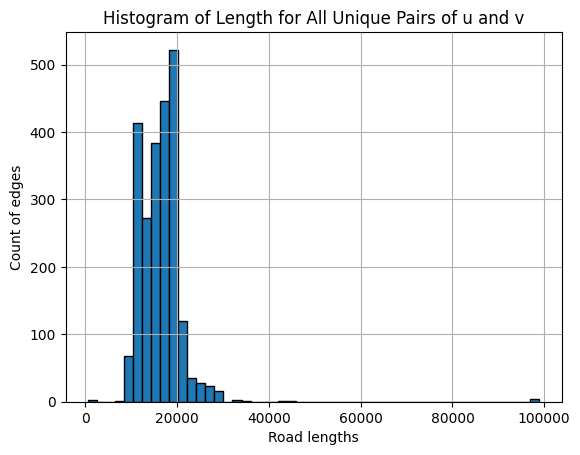

Notice only two edges under 10 000 meters. Thats alright.


In [11]:
pairs_hist = df[['u', 'v']].drop_duplicates().values.tolist()                                   # Get all unique pairs of 'u' and 'v' columns in the DataFrame
lengths = pd.concat([df[(df['u'] == u) & (df['v'] == v)]['length'] for u, v in pairs_hist])     # Concatenate the length column from all subset DataFrames into a single DataFrame

# Create a histogram of the concatenated length column
lengths.hist(bins=50, edgecolor='black')
plt.xlabel('Road lengths')
plt.ylabel('Count of edges')
plt.title('Histogram of Length for All Unique Pairs of u and v')
plt.show()

print('Notice only two edges under 10 000 meters. Thats alright.')



### Investigating Real Traffic Hourly Patterns

In [12]:
#Investigating real traffic hourly patterns of the day based on real data (not pivoted spreadsheet)
hourly=pd.read_csv("/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/roadNetwork_Venv/PythonFiles/trafficAPI/2_TrafficOutputData/completeAllHourlyVolume_EasterAprJulSep.csv")
hourly.head()

,traffic_point_id,year,month,day,from_hour,to_hour,volume,coverage_percentage,timestamp
0,65823V1668921,2018,3,26,00:00,01:00,11,100.00000,2018-03-26 00:00
1,65823V1668921,2018,3,26,01:00,02:00,4,100.00000,2018-03-26 01:00
2,65823V1668921,2018,3,26,02:00,03:00,3,100.00000,2018-03-26 02:00
3,65823V1668921,2018,3,26,03:00,04:00,5,100.00000,2018-03-26 03:00
4,65823V1668921,2018,3,26,04:00,05:00,8,100.00000,2018-03-26 04:00


In [13]:
total_traffic_by_hour = hourly.groupby(['from_hour'])['volume'].sum()       # Group the DataFrame by hour and sum the traffic volume
total_traffic = hourly['volume'].sum()                                      # Calculate the total traffic volume for the entire day
mean_ratios = total_traffic_by_hour / total_traffic                         # Calculate the mean ratio for each hour of the day


In [14]:
mean_ratios

from_hour
00:00   0.00810
01:00   0.00518
02:00   0.00380
03:00   0.00340
04:00   0.00416
05:00   0.01003
06:00   0.03209
07:00   0.05008
08:00   0.04733
09:00   0.04608
10:00   0.05463
11:00   0.06414
12:00   0.06889
13:00   0.07204
14:00   0.07852
15:00   0.08801
16:00   0.08039
17:00   0.06823
18:00   0.05908
19:00   0.04957
20:00   0.04013
21:00   0.03068
22:00   0.02185
23:00   0.01358
Name: volume, dtype: float64

### Checking hourly distribution:

/var/folders/67/gxr6c90j7x9_c9pz8lgvd8n40000gn/T/ipykernel_45053/2035755846.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x_smooth, y_smooth, 'r-', color="darkred", lw=2)                    # Add the spline to the plot


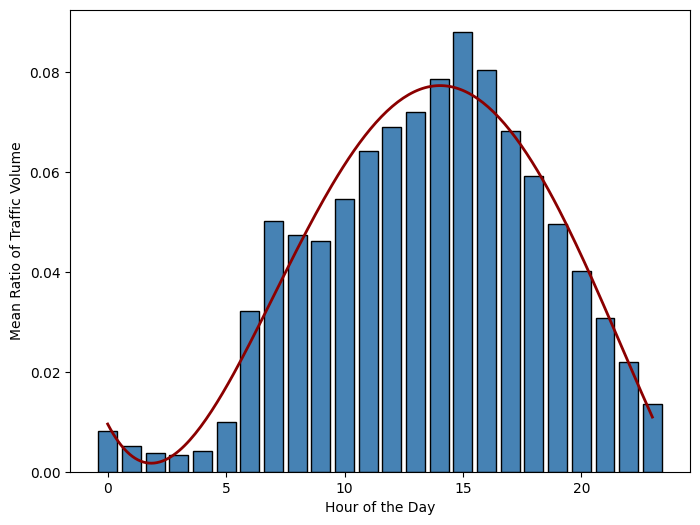

In [15]:
mean_ratios_list = mean_ratios.tolist()         # Convert the mean ratios to a list
hours = mean_ratios.index.tolist()              # Create a list of the hour values

# Extract just the hour from the from_hour column
hours = [int(x.split(':')[0]) for x in hours]  # Convert to integers 

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(hours, mean_ratios_list, edgecolor='black', color="steelblue")       # Create the histogram
ax.set_xlabel('Hour of the Day')                                            # Set the x-axis label
ax.set_ylabel('Mean Ratio of Traffic Volume')                               # Set the y-axis label
x_smooth = np.linspace(min(hours), max(hours), 200)                         # Generate the spline
#spl = make_interp_spline(hours, mean_ratios_list, k=3)                     #Smoothing method 1 : more precise (less nice)
spl = UnivariateSpline(hours, mean_ratios_list, k=4, s=1)                   # Smoothing method 2 : less precise, more smooth (more nice)
y_smooth = spl(x_smooth)
ax.plot(x_smooth, y_smooth, 'r-', color="darkred", lw=2)                    # Add the spline to the plot

plt.show()# Show the plot

In [16]:
hourly.head()

,traffic_point_id,year,month,day,from_hour,to_hour,volume,coverage_percentage,timestamp
0,65823V1668921,2018,3,26,00:00,01:00,11,100.00000,2018-03-26 00:00
1,65823V1668921,2018,3,26,01:00,02:00,4,100.00000,2018-03-26 01:00
2,65823V1668921,2018,3,26,02:00,03:00,3,100.00000,2018-03-26 02:00
3,65823V1668921,2018,3,26,03:00,04:00,5,100.00000,2018-03-26 03:00
4,65823V1668921,2018,3,26,04:00,05:00,8,100.00000,2018-03-26 04:00


In [17]:
df.head()

,u,v,length,traffic_id,volume,Name,CS_id,geometry,Level,PowerKW_list,Number_Of_Chargers,vol_jan,vol_feb,vol_mar,vol_apr,vol_may,vol_jun,vol_jul,vol_aug,vol_sep,vol_oct,vol_nov,vol_dec,range,actual_range_jan,actual_range_feb,actual_range_mar,actual_range_apr,actual_range_may,actual_range_jun,actual_range_jul,actual_range_aug,actual_range_sep,actual_range_oct,actual_range_nov,actual_range_dec,charge_prob_jan,charge_prob_feb,charge_prob_mar,charge_prob_apr,charge_prob_may,charge_prob_jun,charge_prob_jul,charge_prob_aug,charge_prob_sep,charge_prob_oct,charge_prob_nov,charge_prob_dec,charge_cars_jan,charge_cars_feb,charge_cars_mar,charge_cars_apr,charge_cars_may,charge_cars_jun,charge_cars_jul,charge_cars_aug,charge_cars_sep,charge_cars_oct,charge_cars_nov,charge_cars_dec
0,794436,735703,11865.76308,59192V1878201,34276,Frydenlund P-hus,243271,LINESTRING (10.733792828475945 59.909993840978...,3,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22....",15,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334
1,794436,735703,11865.76308,59192V1878201,34276,Tjuvholmen Parkering,215792,LINESTRING (10.733792828475945 59.909993840978...,3,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22....",15,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334
2,794436,735703,11865.76308,59192V1878201,34276,"Recharge Filipstad, Oslo",243223,LINESTRING (10.733792828475945 59.909993840978...,3,"[50.0, 150.0, 50.0, 150.0, 50.0, 150.0, 50.0, ...",16,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334
3,794436,735703,11865.76308,59192V1878201,34276,Recharge K89,243329,LINESTRING (10.733792828475945 59.909993840978...,3,"[50.0, 50.0, 50.0, 50.0, 22.0, 22.0, 22.0, 22....",11,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334
4,794436,735703,11865.76308,59192V1878201,34276,Idas vei,173544,LINESTRING (10.733792828475945 59.909993840978...,3,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0]",8,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334


In [32]:
numCars_df = df[['u', 'v', 'charge_cars_jan', 'charge_cars_feb', 'charge_cars_mar', 'charge_cars_apr', 'charge_cars_may', 'charge_cars_jun', 'charge_cars_jul', 'charge_cars_aug', 'charge_cars_sep', 'charge_cars_oct', 'charge_cars_nov', 'charge_cars_dec']].copy()
numCars_df['idTest'] = numCars_df["u"].astype(str) + "_" + numCars_df["v"].astype(str)

cols = numCars_df.columns.tolist()    # Get a list of the columns
cols = [cols[-1]] + cols[:-1]         # Arrange columns so 'idTest' (the last column in the list) comes first
numCars_df = numCars_df[cols]         # Reorder the DataFrame using the new column list

numCars_df


,idTest,u,v,charge_cars_jan,charge_cars_feb,charge_cars_mar,charge_cars_apr,charge_cars_may,charge_cars_jun,charge_cars_jul,charge_cars_aug,charge_cars_sep,charge_cars_oct,charge_cars_nov,charge_cars_dec
0,794436_735703,794436,735703,338,351,346,335,299,313,217,277,295,336,373,334
1,794436_735703,794436,735703,338,351,346,335,299,313,217,277,295,336,373,334
2,794436_735703,794436,735703,338,351,346,335,299,313,217,277,295,336,373,334
3,794436_735703,794436,735703,338,351,346,335,299,313,217,277,295,336,373,334
4,794436_735703,794436,735703,338,351,346,335,299,313,217,277,295,336,373,334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,973638_973930,973638,973930,3,4,4,4,4,5,8,6,5,4,4,3
2336,973930_1818925,973930,1818925,3,3,4,4,4,5,8,6,4,4,4,3
2337,1818925_832749,1818925,832749,3,4,5,4,5,6,9,7,5,4,4,3
2338,832749_1101914,832749,1101914,3,4,5,4,5,6,9,7,5,4,4,3


In [33]:
cs_data

,u,v,CS_id,PowerKW_list,Number_Of_Chargers,Name
0,794436,735703,243271,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22....",15,Frydenlund P-hus
1,794436,735703,215792,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22....",15,Tjuvholmen Parkering
2,794436,735703,243223,"[50.0, 150.0, 50.0, 150.0, 50.0, 150.0, 50.0, ...",16,"Recharge Filipstad, Oslo"
3,794436,735703,243329,"[50.0, 50.0, 50.0, 50.0, 22.0, 22.0, 22.0, 22....",11,Recharge K89
4,794436,735703,173544,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0]",8,Idas vei
...,...,...,...,...,...,...
2335,973638,973930,0,No CS,0,No CS
2336,973930,1818925,157653,"[22.0, 22.0]",2,Grieg Seafood avd. settefisk
2337,1818925,832749,217034,"[100.0, 50.0, 50.0]",3,Fjellvåkveien 15
2338,832749,1101914,0,No CS,0,No CS


## Calculate Supply From Charging Stations <br>
#### In order to do this, data needs another format:

In [49]:
class CustomJSONEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, pd.core.series.Series):
            return obj.tolist()
        return super(CustomJSONEncoder, self).default(obj)

charging_cols = ['u', 'v', 'CS_id', 'PowerKW_list', 'Number_Of_Chargers', 'Name']

# Create a new DataFrame with the selected columns
cs_data = df[charging_cols].copy()
data_dict = {}                                                      # Initialize an empty dictionary to store the data

# Iterate through the dataframe rows
for index, row in cs_data.iterrows():
    u = row['u']
    v = row['v']
    key = f"{u}_{v}"                                                # Create a key for the unique combination of 'u' and 'v'
    if key not in data_dict:                                        # If the key is not in the dictionary, create a new entry
        data_dict[key] = {'CS_ids': [], 'PowerKW_lists': []}
    data_dict[key]['CS_ids'].append(row['CS_id'])                   # Append the CS_id and PowerKW_list for the current row to the corresponding lists
    if row['PowerKW_list'] == 'No CS':
        data_dict[key]['PowerKW_lists'].append("No CS")
    else:
        data_dict[key]['PowerKW_lists'].append([float(x) for x in ast.literal_eval(row['PowerKW_list'])])

# Convert the dictionary to a JSON object
json_data = json.dumps(data_dict, indent=2, cls=CustomJSONEncoder)

# Print the JSON object
#print(json_data)

with open('edge_cs_data.json', 'w') as f:
    f.write(json_data)

Filter out chargers with less than or equal to ***25 in PowerKWH***:

In [50]:
# Load the JSON data
with open('edge_cs_data.json') as f:
    data = json.load(f)


for key, value in data.items():
    for i, lst in enumerate(value['PowerKW_lists']):
        if isinstance(lst, list):    # Check if lst is a list
            # Use a list comprehension to filter out the values that are equal to 22 and 25
            filtered_lst = [x for x in lst if x not in [22.0, 25.0, 'No CS']]
            # Replace the original list with the filtered list
            value['PowerKW_lists'][i] = filtered_lst

# Save the updated JSON data
with open('updated_json_file.json', 'w') as f:
    json.dump(data, f, indent=2)


In [24]:
# Load the JSON data
with open('edge_cs_data.json') as f:
    data = json.load(f)

# Iterate through each element of the PowerKW_lists arrays
for key, value in data.items():
    for i, lst in enumerate(value['PowerKW_lists']):
        # Use a list comprehension to filter out the values that are equal to 22
        filtered_lst = [x for x in lst if x not in [22.0, 25.0]]
        # Replace the original list with the filtered list
        value['PowerKW_lists'][i] = filtered_lst

# Save the updated JSON data
with open('updated_json_file.json', 'w') as f:
    json.dump(data, f, indent=2)


In [51]:
filtered_lst

[100.0, 50.0, 50.0]

In [52]:
cs_data.head(2)

,u,v,CS_id,PowerKW_list,Number_Of_Chargers,Name
0,794436,735703,243271,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22....",15,Frydenlund P-hus
1,794436,735703,215792,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22....",15,Tjuvholmen Parkering


In [ ]:
cs_data.query('')

Dictionary containing the amount of cars that can charge per hour at chargers with different capacities (data from Excel spreadsheet):

In [53]:
#Set-Up time accounted for (10%)
cars_per_hour_dict={
    350: 4.6,
    300: 4.0,
    250: 3.3,
    200: 2.6,
    180: 2.4,
    175: 2.3,
    150: 2.0,
    135: 1.8,
    129: 1.7,
    125: 1.7,
    120: 1.6,
    100: 1.3,
    75: 1.0,
    62.5: 0.8,
    62: 0.8,
    60: 0.8,
    55: 0.7,
    50: 0.7,
    48: 0.6,
    44: 0.6,
    43: 0.6
}


In [63]:
# Load the updated JSON data
with open('updated_json_file.json') as f:
    python_data = json.load(f)

# Create an empty list to hold the calculated values
calc_values = []

# Loop over each ID in the Python object
for id_, values in python_data.items():
    if not values['CS_ids'] or not all(isinstance(power, (float, int)) for power_list in values['PowerKW_lists'] for power in power_list):      # Skip the iteration if either "CS_ids" or "PowerKW_lists" keys have invalid values
        continue
    total_capacity = sum([sum([cars_per_hour_dict[power] for power in power_list]) for power_list in values['PowerKW_lists']])                  # Calculate the total capacity for the ID by summing the capacities in the "PowerKW_lists" key
    calc_values.append((id_, total_capacity))                                                                                                   # Append the ID and calculated value to the list

# Create a DataFrame from the list of calculated values
edge_supply = pd.DataFrame(calc_values, columns=['ID', 'CalcValue'])

# Print the DataFrame
print(edge_supply)

                 ID  CalcValue
0     794436_735703  379.00000
1    794436_1394577  246.60000
2    794436_1613461   86.40000
3    794436_1337200   64.80000
4     794436_492484   64.80000
..              ...        ...
417   973673_987955    2.70000
418   988264_974905    0.00000
419   974905_975169    0.00000
420  973930_1818925    0.00000
421  1818925_832749    2.70000

[422 rows x 2 columns]


In [64]:
edge_supply = edge_supply.rename(columns={'ID': 'new_id'})
df["new_id"] = df["u"].astype(str) + "_" + df["v"].astype(str)
df.head()


,u,v,length,traffic_id,volume,Name,CS_id,geometry,Level,PowerKW_list,Number_Of_Chargers,vol_jan,vol_feb,vol_mar,vol_apr,vol_may,vol_jun,vol_jul,vol_aug,vol_sep,vol_oct,vol_nov,vol_dec,range,actual_range_jan,actual_range_feb,actual_range_mar,actual_range_apr,actual_range_may,actual_range_jun,actual_range_jul,actual_range_aug,actual_range_sep,actual_range_oct,actual_range_nov,actual_range_dec,charge_prob_jan,charge_prob_feb,charge_prob_mar,charge_prob_apr,charge_prob_may,charge_prob_jun,charge_prob_jul,charge_prob_aug,charge_prob_sep,charge_prob_oct,charge_prob_nov,charge_prob_dec,charge_cars_jan,charge_cars_feb,charge_cars_mar,charge_cars_apr,charge_cars_may,charge_cars_jun,charge_cars_jul,charge_cars_aug,charge_cars_sep,charge_cars_oct,charge_cars_nov,charge_cars_dec,new_id
0,794436,735703,11865.76308,59192V1878201,34276,Frydenlund P-hus,243271,LINESTRING (10.733792828475945 59.909993840978...,3,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22....",15,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703
1,794436,735703,11865.76308,59192V1878201,34276,Tjuvholmen Parkering,215792,LINESTRING (10.733792828475945 59.909993840978...,3,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22....",15,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703
2,794436,735703,11865.76308,59192V1878201,34276,"Recharge Filipstad, Oslo",243223,LINESTRING (10.733792828475945 59.909993840978...,3,"[50.0, 150.0, 50.0, 150.0, 50.0, 150.0, 50.0, ...",16,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703
3,794436,735703,11865.76308,59192V1878201,34276,Recharge K89,243329,LINESTRING (10.733792828475945 59.909993840978...,3,"[50.0, 50.0, 50.0, 50.0, 22.0, 22.0, 22.0, 22....",11,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703
4,794436,735703,11865.76308,59192V1878201,34276,Idas vei,173544,LINESTRING (10.733792828475945 59.909993840978...,3,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0]",8,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703


In [65]:
len(df.drop_duplicates(subset=['u', 'v']))

672

In [66]:
len(edge_supply)

422

In [67]:
edge_supply

,new_id,CalcValue
0,794436_735703,379.00000
1,794436_1394577,246.60000
2,794436_1613461,86.40000
3,794436_1337200,64.80000
4,794436_492484,64.80000
...,...,...
417,973673_987955,2.70000
418,988264_974905,0.00000
419,974905_975169,0.00000
420,973930_1818925,0.00000


#### Merge Dataframes:

In [68]:
# Assuming the other dataframe is called "other_df"
merged_df = df.merge(edge_supply, on='new_id')
merged_df.head()

,u,v,length,traffic_id,volume,Name,CS_id,geometry,Level,PowerKW_list,Number_Of_Chargers,vol_jan,vol_feb,vol_mar,vol_apr,vol_may,vol_jun,vol_jul,vol_aug,vol_sep,vol_oct,vol_nov,vol_dec,range,actual_range_jan,actual_range_feb,actual_range_mar,actual_range_apr,actual_range_may,actual_range_jun,actual_range_jul,actual_range_aug,actual_range_sep,actual_range_oct,actual_range_nov,actual_range_dec,charge_prob_jan,charge_prob_feb,charge_prob_mar,charge_prob_apr,charge_prob_may,charge_prob_jun,charge_prob_jul,charge_prob_aug,charge_prob_sep,charge_prob_oct,charge_prob_nov,charge_prob_dec,charge_cars_jan,charge_cars_feb,charge_cars_mar,charge_cars_apr,charge_cars_may,charge_cars_jun,charge_cars_jul,charge_cars_aug,charge_cars_sep,charge_cars_oct,charge_cars_nov,charge_cars_dec,new_id,CalcValue
0,794436,735703,11865.76308,59192V1878201,34276,Frydenlund P-hus,243271,LINESTRING (10.733792828475945 59.909993840978...,3,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22....",15,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703,379.00000
1,794436,735703,11865.76308,59192V1878201,34276,Tjuvholmen Parkering,215792,LINESTRING (10.733792828475945 59.909993840978...,3,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22....",15,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703,379.00000
2,794436,735703,11865.76308,59192V1878201,34276,"Recharge Filipstad, Oslo",243223,LINESTRING (10.733792828475945 59.909993840978...,3,"[50.0, 150.0, 50.0, 150.0, 50.0, 150.0, 50.0, ...",16,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703,379.00000
3,794436,735703,11865.76308,59192V1878201,34276,Recharge K89,243329,LINESTRING (10.733792828475945 59.909993840978...,3,"[50.0, 50.0, 50.0, 50.0, 22.0, 22.0, 22.0, 22....",11,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703,379.00000
4,794436,735703,11865.76308,59192V1878201,34276,Idas vei,173544,LINESTRING (10.733792828475945 59.909993840978...,3,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0]",8,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703,379.00000


In [69]:
len(merged_df.drop_duplicates(subset=['u', 'v']))

422

Exploring demand data:

In [70]:
merged_df = merged_df.rename(columns={'CalcValue': 'Charge_Supply'})                # rename column

unique_counts = merged_df['Charge_Supply'].value_counts()
unique_values = unique_counts.index.tolist()
occurrences = unique_counts.tolist()

#for i in range(len(unique_values)):
#    print("Charge Supply: {}, Occurrences: {}".format(unique_values[i], occurrences[i]))

merged_df.head()

,u,v,length,traffic_id,volume,Name,CS_id,geometry,Level,PowerKW_list,Number_Of_Chargers,vol_jan,vol_feb,vol_mar,vol_apr,vol_may,vol_jun,vol_jul,vol_aug,vol_sep,vol_oct,vol_nov,vol_dec,range,actual_range_jan,actual_range_feb,actual_range_mar,actual_range_apr,actual_range_may,actual_range_jun,actual_range_jul,actual_range_aug,actual_range_sep,actual_range_oct,actual_range_nov,actual_range_dec,charge_prob_jan,charge_prob_feb,charge_prob_mar,charge_prob_apr,charge_prob_may,charge_prob_jun,charge_prob_jul,charge_prob_aug,charge_prob_sep,charge_prob_oct,charge_prob_nov,charge_prob_dec,charge_cars_jan,charge_cars_feb,charge_cars_mar,charge_cars_apr,charge_cars_may,charge_cars_jun,charge_cars_jul,charge_cars_aug,charge_cars_sep,charge_cars_oct,charge_cars_nov,charge_cars_dec,new_id,Charge_Supply
0,794436,735703,11865.76308,59192V1878201,34276,Frydenlund P-hus,243271,LINESTRING (10.733792828475945 59.909993840978...,3,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22....",15,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703,379.00000
1,794436,735703,11865.76308,59192V1878201,34276,Tjuvholmen Parkering,215792,LINESTRING (10.733792828475945 59.909993840978...,3,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22....",15,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703,379.00000
2,794436,735703,11865.76308,59192V1878201,34276,"Recharge Filipstad, Oslo",243223,LINESTRING (10.733792828475945 59.909993840978...,3,"[50.0, 150.0, 50.0, 150.0, 50.0, 150.0, 50.0, ...",16,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703,379.00000
3,794436,735703,11865.76308,59192V1878201,34276,Recharge K89,243329,LINESTRING (10.733792828475945 59.909993840978...,3,"[50.0, 50.0, 50.0, 50.0, 22.0, 22.0, 22.0, 22....",11,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703,379.00000
4,794436,735703,11865.76308,59192V1878201,34276,Idas vei,173544,LINESTRING (10.733792828475945 59.909993840978...,3,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0]",8,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703,379.00000


Dropping edges were there are **NO charging stations**:

In [71]:
merged_df = merged_df[merged_df['Charge_Supply'] != 0]
unique_values = merged_df['Charge_Supply'].value_counts()
display(merged_df.head())
print(unique_values)

,u,v,length,traffic_id,volume,Name,CS_id,geometry,Level,PowerKW_list,Number_Of_Chargers,vol_jan,vol_feb,vol_mar,vol_apr,vol_may,vol_jun,vol_jul,vol_aug,vol_sep,vol_oct,vol_nov,vol_dec,range,actual_range_jan,actual_range_feb,actual_range_mar,actual_range_apr,actual_range_may,actual_range_jun,actual_range_jul,actual_range_aug,actual_range_sep,actual_range_oct,actual_range_nov,actual_range_dec,charge_prob_jan,charge_prob_feb,charge_prob_mar,charge_prob_apr,charge_prob_may,charge_prob_jun,charge_prob_jul,charge_prob_aug,charge_prob_sep,charge_prob_oct,charge_prob_nov,charge_prob_dec,charge_cars_jan,charge_cars_feb,charge_cars_mar,charge_cars_apr,charge_cars_may,charge_cars_jun,charge_cars_jul,charge_cars_aug,charge_cars_sep,charge_cars_oct,charge_cars_nov,charge_cars_dec,new_id,Charge_Supply
0,794436,735703,11865.76308,59192V1878201,34276,Frydenlund P-hus,243271,LINESTRING (10.733792828475945 59.909993840978...,3,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22....",15,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703,379.00000
1,794436,735703,11865.76308,59192V1878201,34276,Tjuvholmen Parkering,215792,LINESTRING (10.733792828475945 59.909993840978...,3,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22....",15,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703,379.00000
2,794436,735703,11865.76308,59192V1878201,34276,"Recharge Filipstad, Oslo",243223,LINESTRING (10.733792828475945 59.909993840978...,3,"[50.0, 150.0, 50.0, 150.0, 50.0, 150.0, 50.0, ...",16,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703,379.00000
3,794436,735703,11865.76308,59192V1878201,34276,Recharge K89,243329,LINESTRING (10.733792828475945 59.909993840978...,3,"[50.0, 50.0, 50.0, 50.0, 22.0, 22.0, 22.0, 22....",11,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703,379.00000
4,794436,735703,11865.76308,59192V1878201,34276,Idas vei,173544,LINESTRING (10.733792828475945 59.909993840978...,3,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0]",8,34276,35539,35016,38122,37843,41610,30198,38625,38102,39098,38699,33801,300,240,240,240,270,300,315,330,330,306,276,245,240,0.04944,0.04944,0.04944,0.04395,0.03955,0.03767,0.03596,0.03596,0.03878,0.04299,0.04823,0.04944,338,351,346,335,299,313,217,277,295,336,373,334,794436_735703,379.00000


379.00000    80
246.60000    72
489.60000    64
1.40000      62
2.80000      55
             ..
2.40000       1
10.80000      1
6.10000       1
21.00000      1
6.60000       1
Name: Charge_Supply, Length: 150, dtype: int64


In [72]:
len(merged_df.drop_duplicates(subset=['u', 'v']))

360

In [ ]:
#merged_df.to_csv('/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/FinalDataProcessing/AddingFeatures/3_outputData/edgeVolume_wFeatures.csv')

Creating new dataframe keeping only one row for each edge:

In [ ]:
#New dataframe creation which excludes duplicates rows (results in as many rows as edges)
every_edge= merged_df.drop_duplicates(subset='new_id', keep='first')
every_edge.head()

# Supply and Demand Comparison 
#### *Now, lets start comparing supply and demand.*

In [ ]:
# Helper function to distribute the cars per edge using the mean_ratios
def distribute_cars(cars, mean_ratios):
    return [cars * ratio for ratio in mean_ratios]

# Extract hour ratios from mean_ratios
hour_ratios = mean_ratios.values.tolist()

# Prepare a list of month abbreviations
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Initialize an empty dictionary to store the DataFrames for each month
monthly_dfs = {}

# Iterate over each month
for month in months:
    # Create a new DataFrame with the same index as new_df
    monthly_df = every_edge[['u', 'v']].copy()
    # Distribute cars for each edge and each hour of the day
    for hour, ratio in enumerate(hour_ratios):
        hourly_column_name = f'hour_{hour:02d}_{month}'
        monthly_df[hourly_column_name] = every_edge[f'charge_cars_{month}'].mul(ratio)
    
    # Store the resulting DataFrame in the dictionary
    monthly_dfs[month] = monthly_df


Display every dataframe to check *(not necessary)*:

In [ ]:
for month in months:
    display(monthly_dfs[month].head())

### Compare the hourly demand of charging to the fixed supply of charge per edge per hour per month 
**NOTE:** Line 27 & 28 will write the monthly dataframes to directory. Comment this out if not necessary. 

In [ ]:
# Initialize an empty dictionary to store the DataFrames for each month
supply_demand_difference = {}

# Iterate over each month
for month in months:
    # Get the corresponding DataFrame for the month
    monthly_df = monthly_dfs[month].copy()
    
    # Iterate over each hour of the day
    for hour in range(24):
        hourly_column_name = f'hour_{hour:02d}_{month}'
        
        # Calculate the supply-demand difference for each hour
        supply_demand_difference_hour = every_edge['Charge_Supply'] - monthly_df[hourly_column_name]
        
        # Replace the hourly column with the supply-demand difference
        diff_hourly_column_name = f'diff_hour_{hour:02d}_{month}'
        monthly_df[diff_hourly_column_name] = supply_demand_difference_hour

        # Drop the original hourly column
        monthly_df = monthly_df.drop(hourly_column_name, axis=1)
        
    # Store the resulting DataFrame in the dictionary
    supply_demand_difference[month] = monthly_df
    
    # Save the DataFrame to a file with the name "data_month.csv"
    file_path = f"/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/FinalDataProcessing/AddingFeatures/3_outputData/monthlyData/data_{month}.csv"
    monthly_df.to_csv(file_path, index=False)


## Exploring **January** Dataframe:

In [ ]:
supply_demand_difference['jan']

### Check S&D Difference for 100 Edges:

In [ ]:
# Choose the month you want to visualize
month = "jan"

# Prepare the data for the heatmap
data_to_plot = supply_demand_difference[month].drop(["u", "v"], axis=1)

# Pivot the data so that rows represent edges and columns represent hours
data_to_plot["edge"] = supply_demand_difference[month][["u", "v"]].apply(lambda x: f"{x[0]}-{x[1]}", axis=1)
data_to_plot = data_to_plot.set_index("edge")

# Number of rows to display
num_rows = 80

# Set the figure size
plt.figure(figsize=(10, 10))

# Create the heatmap
sns.heatmap(data_to_plot.head(num_rows), cmap="coolwarm", center=0, linewidths=0.1, linecolor="white")

# Add a title to the plot
plt.title(f"Supply-Demand Difference for {month.capitalize()} (Top {num_rows} Edges)")

# Show the plot
plt.show()



### Check Hourly Served/Underserved for 100 Edges:

In [ ]:
# Choose the month you want to visualize
month = "jan"

# Prepare the data for the heatmap
data_to_plot = supply_demand_difference[month].drop(["u", "v"], axis=1)

# Pivot the data so that rows represent edges and columns represent hours
data_to_plot["edge"] = supply_demand_difference[month][["u", "v"]].apply(lambda x: f"{x[0]}-{x[1]}", axis=1)
data_to_plot = data_to_plot.set_index("edge")

# Number of rows to display
num_rows = 80

# Set the figure size
plt.figure(figsize=(10, 10))

# Create custom colormap for the heatmap
custom_cmap = ListedColormap(['red', 'green'])

# Create the heatmap with custom colormap and center at 0
sns.heatmap(data_to_plot.head(num_rows), cmap=custom_cmap, center=0, linewidths=0.1, linecolor="white")

# Add a title to the plot
plt.title(f"Supply-Demand Difference for {month.capitalize()} (Top {num_rows} Edges)")

# Show the plot
plt.show()


*Notice some edges are only underserved some hours a day (making them partially served) - other edges are underserved all hours a day.* 

### Check One Specific Edge:

In [ ]:
# Choose the month you want to visualize
month = "jan"

# Choose the specific edge (u, v) you want to visualize
selected_u = 452203
selected_v = 932993

# Prepare the data for the line chart
edge_data = supply_demand_difference[month].query("u == @selected_u and v == @selected_v")
edge_data = edge_data.drop(["u", "v"], axis=1).T

# Set the figure size
plt.figure(figsize=(10, 7))
plt.plot(edge_data.index, edge_data.values)     # Create the line chart
plt.xlabel("Hours")                             # Add labels and a title to the plot
plt.ylabel("Supply-Demand Difference")
plt.title(f"Supply-Demand Difference for {month.capitalize()} ({selected_u}-{selected_v} Edge)")
plt.xticks(rotation='vertical')                 # Add vertical x-axis text
plt.axhline(0, color='red', linestyle='--')     # Add a horizontal dashed line at y=0

plt.show()                                      # Show the plot


## Categorizing edges by being served, partially served or underserved

In [ ]:
# Select the supply-demand difference DataFrame for January
january_df = supply_demand_difference["jan"].copy()

# Create a new DataFrame to store the classification
classification_df = pd.DataFrame(index=january_df.index, columns=["edge_classification"])

# Iterate over the edges
for edge in january_df.index:
    # Get the supply-demand difference values for the edge
    diff_values = january_df.loc[edge][2:]
    
    # Check if all values are positive
    if (diff_values > 0).all():
        classification = 1
    # Check if all values are negative
    elif (diff_values < 0).all():
        classification = -1
    # Otherwise, the values are mixed
    else:
        classification = 0
    
    # Store the classification for the edge
    classification_df.loc[edge, "edge_classification"] = classification

# Merge the classification DataFrame with the original DataFrame
january_df = pd.concat([january_df, classification_df], axis=1)

# Display the updated DataFrame
january_df.head()


Count number of served/partially served/underserved:

In [ ]:
# Print unique values and their counts
unique_values = january_df['edge_classification'].value_counts()
print(unique_values)


In [ ]:
# Filter the rows where edge_classification is equal to 0 or -1
underserved_edges = january_df.query('edge_classification in (0, -1)')
underserved_edges       # Display the underserved edges


In [ ]:
#Make ID for dataframe so that we can join the geometry and make it QGIS compatible
january_df["new_id"] = january_df["u"].astype(str) + "_" + january_df["v"].astype(str)

# Merge january_df_subset with every_edge on the new_id column
qgis_com_jan = january_df.merge(every_edge[['new_id','geometry']], on='new_id')


In [ ]:
qgis_com_jan.head()

In [ ]:
#qgis_com_jan.to_csv("exploring_january.csv")